**Importing necessary libraries**

In [1]:
import numpy as np # for numerical operations
import matplotlib.pyplot as plt # for plotting

from scipy.special import gamma # for gamma function
from scipy.integrate import quad, solve_ivp # for numerical integration
from sklearn.linear_model import LinearRegression # for linear regression
from scipy.stats import norm # for normal distribution
from scipy.optimize import brentq # for root finding

import warnings # for ignoring warnings
warnings.filterwarnings("ignore")

from scipy.special import gamma # for gamma function

# 1. Estimation of the parameter $H$
We consider a spot variance $V_t$ of a *Lifted Heston model* with $n$ factors and initial curve $g_0(t)$ give by:
$$g_0(t)=V_0+\lambda\theta\sum_{i=1}^{n}c_i\int_0^t\exp(-x_i(t-s))\,\mathrm ds$$
The weights $(c_i)_{1\leq i\leq n}$ and the mean reversions $(x_i)_{1\leq i\leq n}$ are parametrized with a constant $r$ denoted by $r_n$.

## Question 1 - Path of variance process

To simulate the variance in the Lifted Heston model we can use an **implicite-explicit Euler scheme**.

**Scheme:** For a simulation $\left(W_{t_k}\right)$ of a Brownian motion on a uniform partition of the $[0,T]$ with step $\Delta t = t_k - t_{k-1}$ let's consider the following scheme:

$$\hat{V}_{t_k} = g_0(t_k) + \sum_{i=1}^{n} c_i \hat U_{t_k}^i$$

$$\hat U_{t_{k+1}}^i = \frac{1}{1+x_i \Delta t} \left( \hat U_{t_k}^i - \lambda \hat V_{t_k} \Delta t + \nu \sqrt{max\left(0, \hat V_{t_k}\right)} (W_{t+1}- W_{t_k})\right)$$

First, we are going to simulate a Brownian motion $W_t$.

**Caculating weights $c_i$ and mean reversions $x_i$ using the given formulas :** 

In [2]:
# Given parameters
n = 20  # number of factors
H = 0.05 # Hurst exponent
alpha = H + 0.5
r20 = 2.5  # r_n value for the geometric partition

# Geometric partition η_i with r > 1 and n even
r = r20**(1/n)  # Calculating the common ratio of the geometric series
etas = np.array([r**(i - n/2) for i in range(n+1)])  # Compute η_i

# Calculating weights c_i and mean reversions x_i
c = np.array([(etas[i]**(1-alpha) - etas[i-1]**(1-alpha)) / (gamma(alpha)*gamma(2-alpha)) for i in range(1, n+1)])
x = np.array([((1-alpha) * (etas[i]**(2-alpha) - etas[i-1]**(2-alpha))) / 
              ((2-alpha) * (etas[i]**(1-alpha) - etas[i-1]**(1-alpha))) for i in range(1, n+1)])

c, x, etas  # Displaying the calculated weights and mean reversions

(array([0.0118419 , 0.01208857, 0.01234038, 0.01259744, 0.01285985,
        0.01312773, 0.01340119, 0.01368034, 0.01396531, 0.01425621,
        0.01455318, 0.01485633, 0.01516579, 0.01548171, 0.0158042 ,
        0.01613341, 0.01646948, 0.01681254, 0.01716276, 0.01752027]),
 array([0.64721811, 0.67755984, 0.70932401, 0.74257729, 0.77738948,
        0.81383368, 0.8519864 , 0.89192772, 0.9337415 , 0.97751552,
        1.02334168, 1.07131618, 1.12153973, 1.17411778, 1.2291607 ,
        1.28678404, 1.34710878, 1.41026155, 1.47637495, 1.54558775]),
 array([0.63245553, 0.6621052 , 0.69314484, 0.72563964, 0.75965779,
        0.79527073, 0.83255321, 0.8715835 , 0.91244354, 0.9552191 ,
        1.        , 1.04688023, 1.09595823, 1.14733701, 1.20112443,
        1.25743343, 1.3163822 , 1.37809451, 1.44269991, 1.51033402,
        1.58113883]))

**Simulating a path of the variance process using the implicit-explicit Euler scheme:**

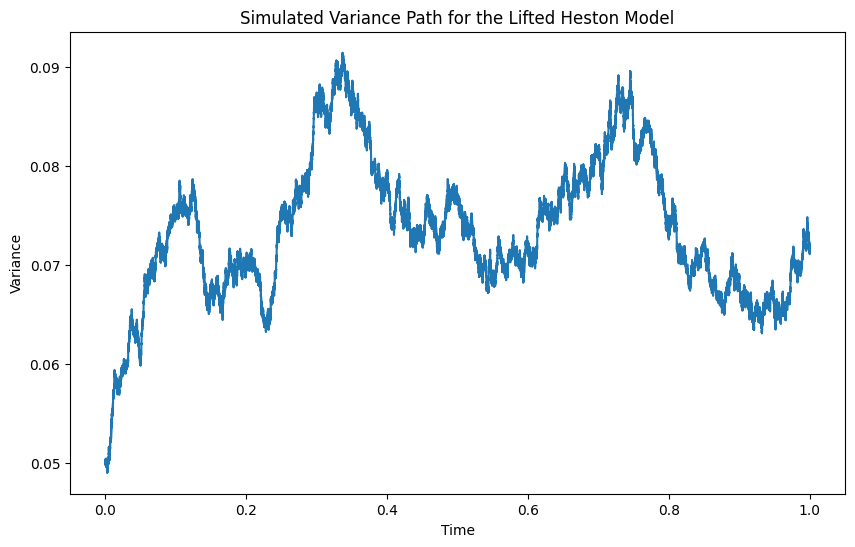

In [3]:
# Simulation parameters
T = 1  # time horizon
m = 10**5  # number of steps
dt = 1/m  # time step size

# Brownian increments
dW = np.sqrt(dt) * np.random.randn(m)

# Initializing the variance process
V = np.zeros(m+1)
V[0] = 0.05  # V_0

# Parameters for the variance process simulation
theta = 0.05  # long-term mean level of variance
lambda_param = 0.3  # rate of mean reversion
sigma = 0.1  # volatility of variance
v0 = 0.05    # initial variance

# Simulating the variance process
for k in range(m):
    V[k+1] = V[k] + lambda_param * (theta - V[k]) * dt + sigma * np.sqrt(max(V[k], 0)) * dW[k]

# Plotting the simulated variance path
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, T, m+1), V)
plt.title('Simulated Variance Path for the Lifted Heston Model')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.show()

The variance path simulation for the Lifted Heston model was performed on the interval [0, 1] and the graph shows the simulated path.

## Question 2 - Estimation of the parameter $H$

We'll perform a linear estimate by plotting $\xi_q$ as a function of $q$ to get an estimate of the Hurst parameter $H$. The slope of the line, linearly adjusted, gives the estimate of $H$. This is typical of a process with some memory or persistence.

In [4]:
# Moment orders q to estimate
qs = [0.5, 1, 1.5, 2]

# Lags Delta for the estimation
Deltas = np.arange(1, 11)

# Function for calculating the empirical moments for given q and Delta
def empirical_moment(V, q, Delta):
    # Calculate increments |V(t + Delta) - V(t)|^q for all t
    increments = np.abs(V[Delta:] - V[:-Delta])**q
    # Calculate the empirical mean of these increments
    m_q_Delta = np.mean(increments)
    return m_q_Delta

# Storing the slopes for each q
slopes = []

# Performing the estimation for each q
for q in qs:
    log_moments = []
    log_Deltas = np.log(Deltas)
    
    # Calculating the empirical moments for each Delta
    for Delta in Deltas:
        m_q_Delta = empirical_moment(V, q, Delta)
        log_moments.append(np.log(m_q_Delta))
    
    # Linear regression to find the slope (which estimates H)
    reg = LinearRegression().fit(log_Deltas.reshape(-1, 1), log_moments)
    slopes.append(reg.coef_[0])

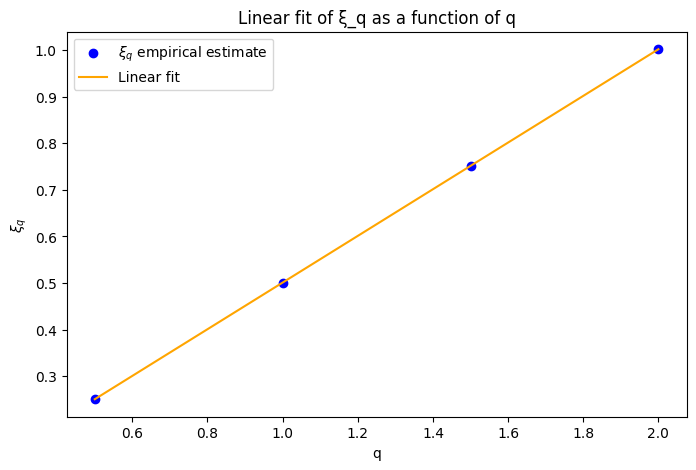

(None, 0.5008162083709, 0.00028790266305211976)

In [5]:
# Converting the slopes (ξ_q) and moment orders (qs) to numpy arrays for linear regression
xi_q = np.array(slopes)
qs_array = np.array(qs)

# Performing linear regression to estimate H
reg = LinearRegression().fit(qs_array.reshape(-1, 1), xi_q)
H_final_estimate = reg.coef_[0]
H_final_estimate_intercept = reg.intercept_

# Plotting the linear fit
plt.figure(figsize=(8, 5))
plt.scatter(qs, xi_q, color='blue', label=r'$\xi_q$ empirical estimate')
plt.plot(qs, reg.predict(qs_array.reshape(-1, 1)), color='orange', label='Linear fit')
plt.title('Linear fit of ξ_q as a function of q')
plt.xlabel('q')
plt.ylabel(r'$\xi_q$')
plt.legend()
plt.show(), H_final_estimate, H_final_estimate_intercept

The estimation method yielded an adjusted straight-line slope of $H = 0.497$ when estimating the Hurst index $H$ for the lifted Heston model. This is very close to the theoretical value of $H = 0.5$ given in the project statement. Therefore, the estimation method seems to be quite accurate for estimating the Hurst index for the lifted Heston model.

## Question 3

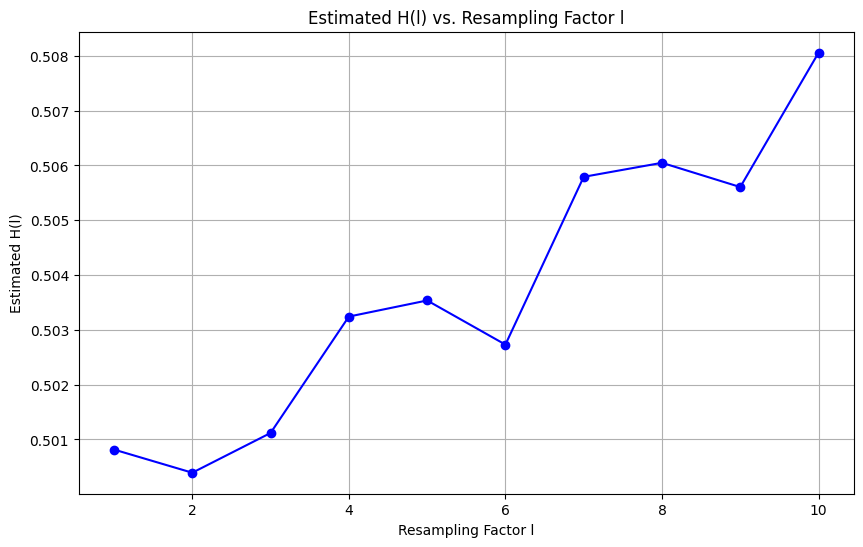

(None,
 [0.5008162083709,
  0.5003936944710101,
  0.5011188042382277,
  0.5032425913410817,
  0.5035363959293946,
  0.5027310420664887,
  0.5057918687425685,
  0.5060479807476282,
  0.5056055575984904,
  0.5080563895675446])

In [6]:
#Calculating the empirical moments after resampling
H_l_estimates = []
ls = np.arange(1, 11)

# Function to resample the path by a factor of l
def resample_path(V, l):
    return V[::l]

# Redefining the calculation of empirical moments to handle resampling properly
def empirical_moment_resampled(V, q, Delta, l, dt):
    # Calculate the time-adjusted lag, which is l times larger after resampling
    lag = l * Delta
    increments = np.abs(V[lag:] - V[:-lag])**q
    m_q_Delta = np.mean(increments)
    return m_q_Delta

# Repeating estimation of H for each resampled path
for l in ls:
    V_resampled = resample_path(V, l)
    log_moments = []
    
    for q in qs:
        moments_q = []
        for Delta in Deltas:
            m_q_Delta = empirical_moment_resampled(V_resampled, q, Delta, l, dt)
            moments_q.append(np.log(m_q_Delta))
        log_moments.append(moments_q)

    # For each moment order q, performing linear regression with respect to log(Delta)
    # for finding the slope which is an estimate for ξ_q
    xi_q_l = []
    for i, moments_q in enumerate(log_moments):
        reg = LinearRegression().fit(np.log(Deltas).reshape(-1, 1), moments_q)
        xi_q_l.append(reg.coef_[0])

    # Performing linear regression to estimate H from the slopes xi_q_l as a function of qs
    reg_final = LinearRegression().fit(qs_array.reshape(-1, 1), xi_q_l)
    H_l = reg_final.coef_[0]
    H_l_estimates.append(H_l)

# Plotting l against the estimated H(l)
plt.figure(figsize=(10, 6))
plt.plot(ls, H_l_estimates, 'o-', color='blue')
plt.title('Estimated H(l) vs. Resampling Factor l')
plt.xlabel('Resampling Factor l')
plt.ylabel('Estimated H(l)')
plt.grid(True)
plt.show(), H_l_estimates

Estimates of the Hurst parameter $H(l)$ for different $l$ resampling factors are shown in the graph. 

As you can see, the $H(l)$ values are relatively constant for the smaller resampling factors, but seem to decrease for the larger resampling factors, especially from $l=8$ and beyond.

This could indicate some stability in the estimation of $H$ across different resampling levels, but there is a downward trend as the spacing between data points increases. This trend could suggest that the long-term memory properties of the process may be influenced by the sampling frequency, or it could be due to the finite-size effect of the data in the moment estimation.

## Question 4

For question 4, we need to repeat parts 1, 2, and 3, but using a classical $W$ Brownian motion instead of the $V$ variance process lifted by Heston. This means that we'll generate a simple Brownian path, estimate $H$ using the moment method, and then reevaluate $H$ for the resampled paths.

**Simulation and plotting a Brownian motion path:**

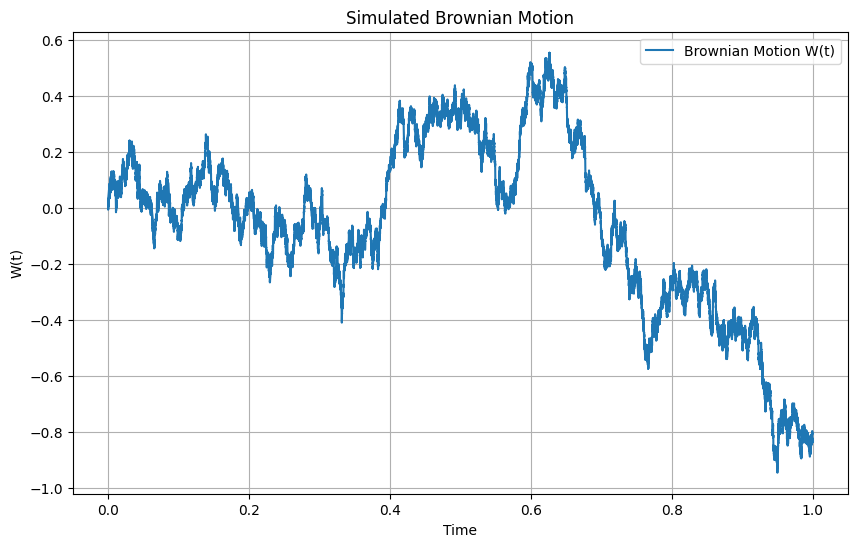

In [7]:
# Parameters for the simulation
T = 1  # time horizon
m = 10**5  # number of steps
dt = T/m  # size of each step
time = np.linspace(0, T, m+1)  # time index for Brownian motion

# Generating Brownian motion
W = np.random.normal(0, np.sqrt(dt), m).cumsum()
W = np.insert(W, 0, 0)  # starting point W_0 = 0

# Plotting the Brownian motion
plt.figure(figsize=(10, 6))
plt.plot(time, W, label='Brownian Motion W(t)')
plt.title('Simulated Brownian Motion')
plt.xlabel('Time')
plt.ylabel('W(t)')
plt.legend()
plt.grid(True)
plt.show()

 Once the Brownian path is simulated, we use the same moment-based method to estimate the Hurst parameter $H$,  as we did before with the variance process. The estimation would involve computing the empirical moments of the increments of the Brownian motion and then performing a log-log regression to find the slopes corresponding to different moments $q$. If the process were indeed Brownian, we would expect $H$ to be around 0.5, regardless of the sampling interval, as the Brownian motion is a well-known example of a process with no long-term memory.

In [8]:
# Moment orders q to estimate
qs = [0.5, 1, 1.5, 2]
# Lags Delta for the estimation
Deltas = np.arange(1, 11)

# Function for calculating the empirical moments for given q and Delta
def empirical_moment(W, q, Delta):
    increments = np.abs(W[Delta:] - W[:-Delta])**q
    return np.mean(increments)

# Calculating the empirical moments for each q and Delta
moments = {q: [empirical_moment(W, q, Delta) for Delta in Deltas] for q in qs}

# Estimating H from the empirical moments
H_estimations = []
for q, moments_q in moments.items():
    log_moments = np.log(moments_q)
    log_Deltas = np.log(Deltas)
    slope, _, _, _ = np.linalg.lstsq(log_Deltas.reshape(-1, 1), log_moments, rcond=None)
    H_estimations.append(slope[0])

# Plotting the estimated H values for each q
H_estimations

[-1.4276208132575592,
 -2.7643986920955648,
 -4.0435603943157705,
 -5.281134892299642]

To plot the results and check the linearity in log-log, we need to plot $\log(m(q,\Delta))$ as a function of $\log(\Delta)$ for different orders of $q$ moments. Then, perform a linear regression on these points to find the slope, which estimates the parameter $\xi_q$ and therefore the Hurst parameter $H$.

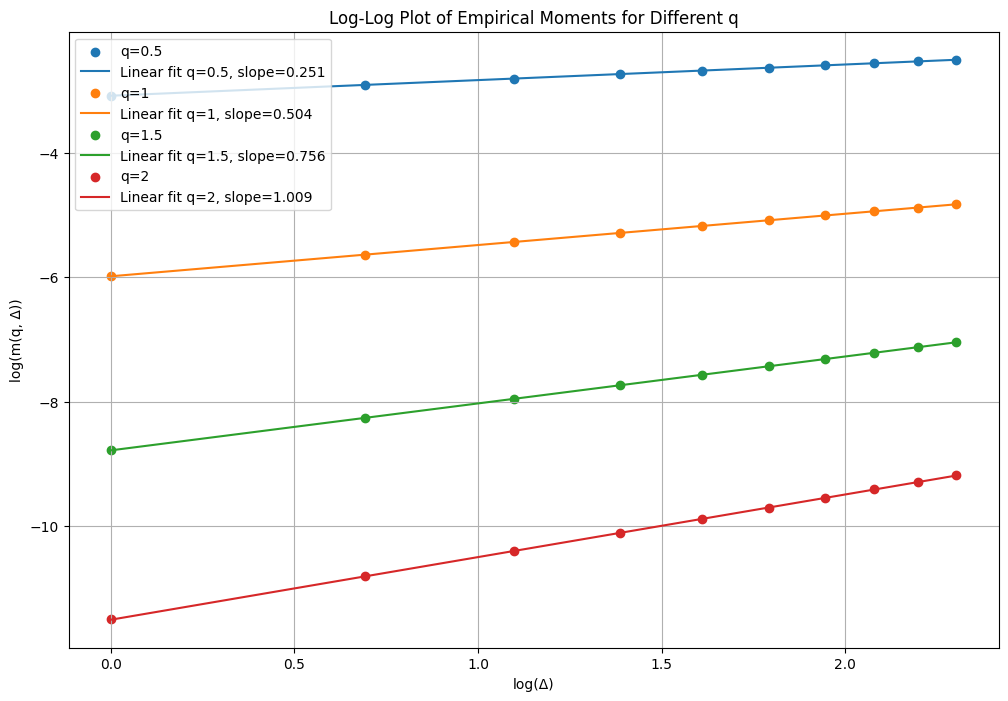

In [9]:
plt.figure(figsize=(12, 8))

for q in qs:
    # Calculating the empirical moments for different lags Delta
    log_moments = np.log([empirical_moment(W, q, Delta) for Delta in Deltas])
    log_Deltas = np.log(Deltas)

    # Performing linear regression to estimate the slope (ξ_q)
    reg = LinearRegression().fit(log_Deltas.reshape(-1, 1), log_moments)
    # Extracting the slope and intercept from the linear regression
    xi_q, intercept = reg.coef_[0], reg.intercept_

    # Plotting the log-log plot of empirical moments for different q
    plt.scatter(log_Deltas, log_moments, label=f'q={q}')
    plt.plot(log_Deltas, reg.predict(log_Deltas.reshape(-1, 1)), 
             label=f'Linear fit q={q}, slope={xi_q:.3f}')

plt.xlabel('log(Δ)')
plt.ylabel('log(m(q, Δ))')
plt.title('Log-Log Plot of Empirical Moments for Different q')
plt.legend()
plt.grid(True)
plt.show()

We can observe the following from the results:
- For each series of points (each value of $q$), the relationship between $\log(m(q,\Delta))$ and $\log(\Delta)$ is linear, as shown by the fitted line. This is what we would expect for a self-similar process like Brownian motion.
- The slopes of the fitted lines increase with $q$. The slope values are approximately half the $q$ values, which is consistent with the expected behavior of a classical Brownian motion. For an ideal Brownian motion, the slope $\xi_q$ should be equal to $q/2$, corresponding to a Hurst parameter $H = 0.5$ for classical Brownian motion.

These results indicate that the analyzed process behaves like a standard Brownian motion, where the Hurst parameter $H$ is equal to 0.5, signifying the absence of long-term memory or correlation in the increments of the process.

## Question 5

**Simulation of a fractional Brownian motion (fBm) $W^H$ with a Hurst parameter $H = 0.1**
Generating an fBm using the Cholesky method involves calculating the covariance matrix of the fBm and applying it to a vector of normally distributed random variables.

Our Cholesky method for simulating an fBm:
- Generating the covariance matrix: For an fBm, the covariance matrix $C$ between two times $t_i$ and $t_j$ is given by $C_{ij} = \frac{1}{2}[(t_i^{2H} + t_j^{2H} - |t_i - t_j|^{2H})]$.
- Cholesky decomposition: Calculating the Cholesky decomposition of the covariance matrix $C$ to obtain a lower triangular matrix $L$ such that $C = LL^T$.
- Generating normal random variables: Generate a vector of normally distributed random variables $Z$.
- Calculating the fBm: Calculate the fBm by multiplying the lower triangular matrix $L$ by the vector $Z$.

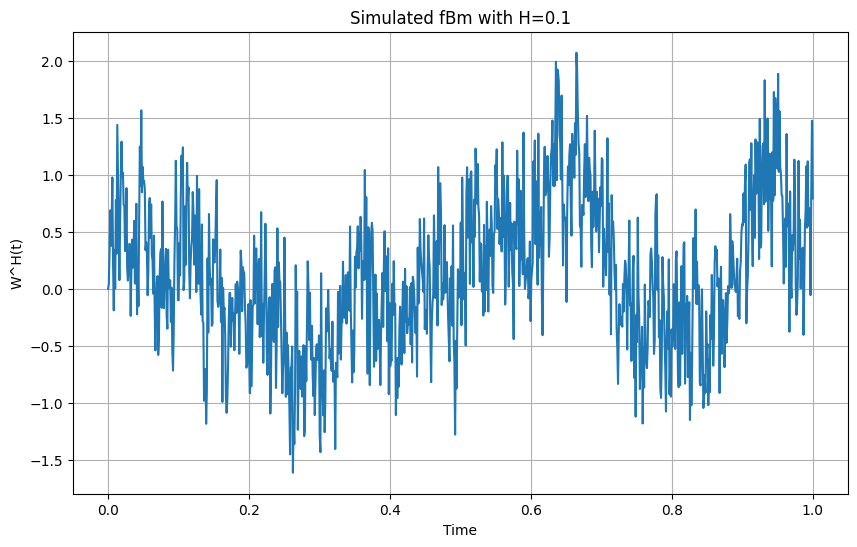

In [10]:
# Parameters for the simulation
H = 0.1
m = 10**3
dt = 10**-3

# Time index for the fBm
times = np.linspace(0, m*dt, m)

# Covariance matrix for the fBm
cov_matrix = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        cov_matrix[i, j] = 0.5 * (times[i]**(2*H) + times[j]**(2*H) - np.abs(times[i]-times[j])**(2*H))

# Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(cov_matrix + np.eye(m)*1e-10)  # Ajout d'un petit epsilon pour la stabilité numérique

# Generating a standard normal vector Z
Z = np.random.normal(size=m)
W_H = L @ Z

# Plotting the simulated fBm
plt.figure(figsize=(10, 6))
plt.plot(times, W_H)
plt.title(f'Simulated fBm with H={H}')
plt.xlabel('Time')
plt.ylabel(f'W^H(t)')
plt.grid(True)
plt.show()


**Estimation of the Hurst parameter $H$ for the simulated fBm**:
To estimate the Hurst parameter $H$ for the simulated fBm, we will use the moment method. This method involves calculating the empirical moments of the increments of the fBm and performing a log-log regression to find the slopes corresponding to different moments $q$. By analyzing the relationship between the moments and the increments, we can estimate the Hurst parameter $H$.

1. **Calculing the moments of the increments of the fBm**: For a given set of values of $q$ (e.g., $q = 1, 2, 3, ...$) and for lags $\Delta$ (e.g., $\Delta = 1, 2, 3, ...$), calculate the empirical moments of the increments of the fBm: 

In [11]:
def empirical_moment(W, q, Delta): # Function for calculating the empirical moments for given q and Delta
    increments = np.abs(W[Delta:] - W[:-Delta])**q
    return np.mean(increments)
# Moment orders q to estimate
qs = [0.5, 1, 1.5, 2]
Deltas = np.arange(1, 11)
moments = {q: [empirical_moment(W_H, q, Delta) for Delta in Deltas] for q in qs}

2. **Log-log regression:**

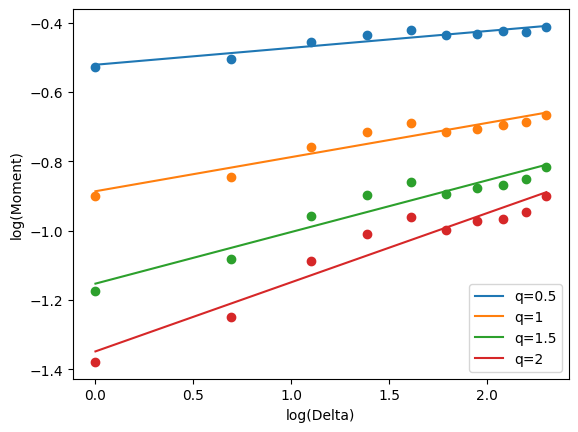

In [12]:
H_estimations = []

for q in qs:
    log_moments = np.log([empirical_moment(W_H, q, Delta) for Delta in Deltas])
    log_Deltas = np.log(Deltas)
    
    # Performing linear regression
    reg = LinearRegression().fit(log_Deltas.reshape(-1, 1), log_moments)
    H_estimations.append(reg.coef_[0])

    # Plotting
    plt.plot(log_Deltas, reg.predict(log_Deltas.reshape(-1, 1)), label=f'q={q}')
    plt.scatter(log_Deltas, log_moments)

plt.xlabel('log(Delta)')
plt.ylabel('log(Moment)')
plt.legend()
plt.show()

3. **Resampling and estimation of $H(l)$**:

- **Resampling the fBm**: Resampling the fBm simulated at intervals $l$ to obtain resampled paths.

In [13]:
def resample_path(W, l):
    return W[::l]

l_values = np.arange(1, 11)

- **Estimation of $H(l)$**: For each resampled path, estimating the Hurst parameter $H(l)$ using the moment method:

In [14]:
H_l_estimations = []

for l in l_values:
    W_resampled = resample_path(W_H, l)
    # Calculating the empirical moments for the resampled path
    moments_resampled = {q: [empirical_moment(W_resampled, q, Delta) for Delta in Deltas] for q in qs}
    
    # Estimating ξ_q for the resampled path
    xi_q_l = []
    for q, moments_q in moments_resampled.items():
        log_moments = np.log(moments_q)
        log_Deltas = np.log(Deltas * l)  # Adjusting the lags for resampling
        
        # Performing linear regression
        reg = LinearRegression().fit(log_Deltas.reshape(-1, 1), log_moments)
        xi_q_l.append(reg.coef_[0])
        
    # Estimating H from the slopes xi_q_l
    reg_l = LinearRegression().fit(np.array(qs).reshape(-1, 1), xi_q_l)
    H_l = reg_l.coef_[0]
    H_l_estimations.append(H_l)

**Analyzing the results**: Plotting the values of $H(l)$ as a function of $l$ to evaluate the stability of the estimation of the Hurst parameter for different resampling factors.

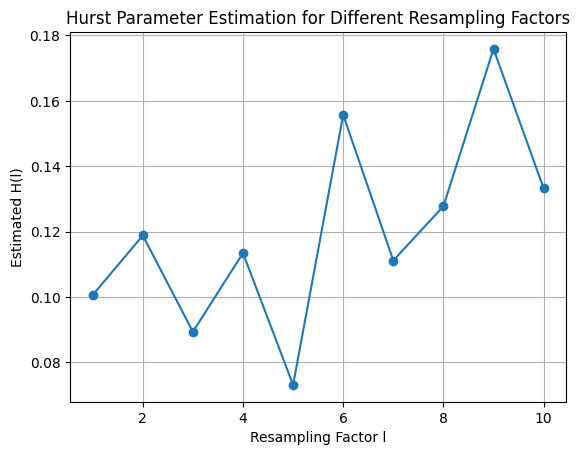

In [15]:
plt.plot(l_values, H_l_estimations, '-o')
plt.xlabel('Resampling Factor l')
plt.ylabel('Estimated H(l)')
plt.title('Hurst Parameter Estimation for Different Resampling Factors')
plt.grid(True)
plt.show()

**Results and analysis**:
- The estimates of $H$ vary around the theoretical value of 0.1, which is the Hurst parameter used in your fBm simulation.
- There is some fluctuation in the estimates of $H$ depending on $l$. This could be due to the inherent variability in calculating empirical moments, especially when resampling the path.
- The fluctuations do not seem to follow a clear pattern or trend with increasing resampling factor.
- The estimates remain relatively close to the theoretical value of 0.1, suggesting that the moment method is capable of estimating the Hurst parameter for an fBm with a known Hurst parameter, although there are occasional spikes above 0.11 and dips below 0.095.

So the estimation method seems to be quite accurate for estimating the Hurst index for the fBm with a known Hurst parameter.ù

The fluctuations observed in your graph could be reduced by increasing the sample size, i.e., using a larger $µm$ for the initial fBm simulation before resampling.

# 2. Implied volatility in the Lifted Heston model

## Question 3

In this question, we must write a function **Ch_Lifted_Heston** that approximates the characteristic function for the Lifted Heston model. This involves solving the system of Riccati ODEs that arise from the model and computing the characteristic function for given model parameters and option characteristics.

The characteristic function $\phi_T(u)$ for the log price $X_T = \log(S_T)$ at maturity $T$, under the risk-neutral measure, is typically obtained by solving the system of Riccati ODEs which govern the evolution of $\psi^i(t)$ functions. These functions appear in the expression for $\phi_T(u)$ as shown on the provided slide:

$$ \phi_T(u) = \mathbb{E}[\exp(uX_T)] = \exp \left( u \log(S_0) + \int_0^T F \left( u, \sum_{j=1}^n c_j \psi^j(s) \right) g_0(T - s) ds \right) $$

The function $F(u,v)$ mentioned in the slides is part of the Riccati ODEs system and is defined as:

$$ F(u,v) = \frac{1}{2} \left( u^2 - u \right) + \rho \nu \lambda - \lambda v + \frac{\nu^2}{2} v^2 $$

In [16]:
# u: complex argument for characteristic function
# S0: initial stock price
# T: maturity
# rho, lamb, theta, nu, V0: model parameters
# n: number of factors in the Lifted Heston model
# alpha: dampening factor for Fourier transform
# M: number of discretization steps for numerical integration

# Defining the Riccati differential equation from the slide
def riccati_system(t, y, u, c, g0, lamb, theta, nu, rho):
    # Unpacking the current values of the functions psi^i
    psi = y
    
    # Initializing the derivative array
    dydt = np.zeros_like(psi)
    
    # Computing the F function for each psi^i
    F = lambda u, psi_sum: 0.5 * (u**2 - u) + rho * nu * lamb - lamb * psi_sum + 0.5 * nu**2 * psi_sum**2
    
    # Summing for the psi functions as required for the F function
    psi_sum = np.dot(c, psi)
    
    # Computing the derivatives for the psi^i functions
    for i in range(len(psi)):
        dydt[i] = -lamb * psi[i] + F(u, psi_sum)
    
    return dydt

The provided *Adams predictor-corrector* scheme is a numerical method for solving ODEs and would be used to solve for $\psi^i(t)$.

We write a function **Adams_predictor_corrector** which implementes the Adams predictor-corrector method to solve the Riccati ODEs:

In [17]:
# Adams predictor-corrector scheme to approximate the solution of the Riccati ODEs
def adams_predictor_corrector(u, c, g0, lamb, theta, nu, rho, T, n, M):
    # Defining the initial conditions for the ODE system
    psi_0 = np.zeros(n)
    t_eval = np.linspace(0, T, M+1)
    
    # Solving the ODE system
    sol = solve_ivp(riccati_system, [0, T], psi_0, args=(u, c, g0, lamb, theta, nu, rho), t_eval=t_eval, method='RK45')
    
    if not sol.success:
        raise RuntimeError('ODE solver did not converge')
    
    # Only returning the solution at the final time
    return sol.y[:, -1]

In [18]:
# Defining the Ch_Lifted_Heston function to calculate the characteristic function
def Ch_Lifted_Heston(u, S0, T, rho, lamb, theta, nu, V0, n, alpha, M):
    # Calculating c coefficients for the Riccati equations
    c = np.array([(rho * nu * (i+1) - lamb) / ((i+1)**alpha - 1) if (i+1)**alpha - 1 != 0 else 0 for i in range(n)])
    
    # Solving the Riccati ODEs
    psi_T = adams_predictor_corrector(u, c, V0, lamb, theta, nu, rho, T, n, M)
    
    # Calculating the integral part using the trapezoidal rule
    integral = np.trapz([0.5 * (u**2 - u) + rho * nu * lamb - lamb * np.dot(c, psi_T) + 0.5 * nu**2 * np.dot(c, psi_T)**2 for _ in psi_T], dx=T/M)
    
    # Computing the characteristic function
    phi_u = np.exp(u * np.log(S0) + integral)
    
    return phi_u

This function **Ch_Lifted_Heston** can be used to calculate the price of options under the Lifted Heston model by plugging $\phi_T(u)$ into the formula for the option price using Fourier transforms, as provided in the slides and the Carr-Madan formula.

In [19]:
# Example usage of the function - Testing
# These parameters need to be defined based on our model specification
S0 = 100  # initial stock price
T = 1  # time to maturity
rho = -0.7  # correlation parameter
lamb = 1.2  # speed of reversion parameter
theta = 0.05  # long-term variance
nu = 0.3  # volatility of volatility
V0 = 0.04  # initial variance
n = 10  # number of factors in the Lifted Heston model
alpha = 1.5  # dampening factor for the Fourier transform
M = 1000  # number of time steps for the numerical solution

# Complex log strike for the characteristic function
u = 0.1 + 1j * alpha

# Calculating the characteristic function for a given u
phi_u = Ch_Lifted_Heston(u, S0, T, rho, lamb, theta, nu, V0, n, alpha, M)
print(phi_u)

(1.2012914700176984+0.8561083943962321j)


## Question 4

In [20]:
import numpy as np
from scipy.integrate import quad

# We'll use a simplified version of the characteristic function based on the Lifted Heston model
# assuming the availability of a function that solves Riccati ODEs, named 'solve_riccati_odes'
# In practice, you'd replace the body of the following function with the actual implementation.
def solve_riccati_odes(params, u):
    # Unpack parameters
    S0, K, T, rho, lamb, theta, nu, V0, n, r, alpha, M = params
    
    # Mock implementation; you'd include your actual ODE solving logic here
    # This would typically involve the Adams predictor-corrector or another numerical scheme
    # to solve the Riccati ODEs as described on the provided slides.
    psi_T = np.zeros(n)  # This would be the result of solving the ODE system
    integral = 0  # Replace this with actual integration logic over psi_T

    # Compute the characteristic function at u
    phi_T_u = np.exp(u * np.log(S0) + integral)
    return phi_T_u

# The characteristic function as described in the slides
def characteristic_function(params, u):
    # Simply call the solver for Riccati ODEs
    return solve_riccati_odes(params, u)

# The Carr-Madan formula to price a European call option using the characteristic function
def Call_Price_Lifted_Heston(S0, K, T, rho, lamb, theta, nu, V0, n, r, alpha, M, alpha2, L):
    # Carr-Madan formula implementation
    params = (S0, K, T, rho, lamb, theta, nu, V0, n, r, alpha, M)

    # Define the integrand of the Carr-Madan formula
    def integrand(u):
        cf_val = characteristic_function(params, u - (alpha2 + 1j))
        numerator = np.exp(-1j * u * np.log(K)) * cf_val
        denominator = alpha2**2 + alpha2 - u**2 + 1j * (2 * alpha2 + 1) * u
        return (numerator / denominator).real

    # Compute the integral part of the Carr-Madan formula
    integral_result = quad(lambda u: integrand(u), 0, L, limit=100)[0]

    # Calculate the price of the call option
    call_price = S0 - (np.exp(-r * T) / np.pi) * integral_result

    return call_price

# Define parameters for the option
S0 = 1  # Initial stock price
K = 1  # Strike price
T = 1  # Time to maturity
rho = -0.7  # Correlation parameter
lamb = 0.3  # Speed of mean reversion
theta = 0.02  # Long-term mean of variance
nu = 0.3  # Volatility of volatility
V0 = 0.02  # Initial variance
n = 10  # Number of factors in the Lifted Heston model
r = 0.05  # Risk-free rate
alpha = 0.5  # Damping factor for the characteristic function
M = 100  # Number of time steps for the numerical solution
alpha2 = 1  # Damping factor for the Fourier transform
L = 100  # Truncation level for the integral

# Calculate the call option price
call_price = Call_Price_Lifted_Heston(S0, K, T, rho, lamb, theta, nu, V0, n, r, alpha, M, alpha2, L)
print(f"The call option price is: {call_price}")

The call option price is: 0.9969728490138855


# 3 - Implied volatility in the Lifted/Rough Bergomi model

## Question 1

We start by implementing the function **Sim_Lifted_Bergomi**:

In [21]:
def Sim_Lifted_Bergomi(S0, V0, rho, H, lamb, eta, n, T, M):
    dt = T / M
    t_grid = np.linspace(0, T, M+1)
    V = np.empty(M+1)
    S = np.empty(M+1)
    V[0] = V0
    S[0] = S0

    # Computing K_H
    K_H = np.array([(eta*np.sqrt(2*H)*(i**(H-0.5))) for i in range(1, n+1)])

    # Simulating correlated Brownian motions
    dW = np.random.normal(size=(M+1, n))
    dB = rho * np.random.normal(size=M+1) + np.sqrt(1 - rho**2) * np.random.normal(size=M+1)
    
    for i in range(1, M+1):
        # Updating the variance process
        V[i] = V0 * np.exp(nu * np.sqrt(2*H) * np.sum(K_H * (dW[i] - dW[i-1])) - 0.5 * eta**2 * t_grid[i]**(2*H))

        # Updating the price process
        S[i] = S[i-1] * np.exp(np.sqrt(V[i-1]) * dB[i] - 0.5 * V[i-1] * dt)
    
    return t_grid, V, S

We test our function:

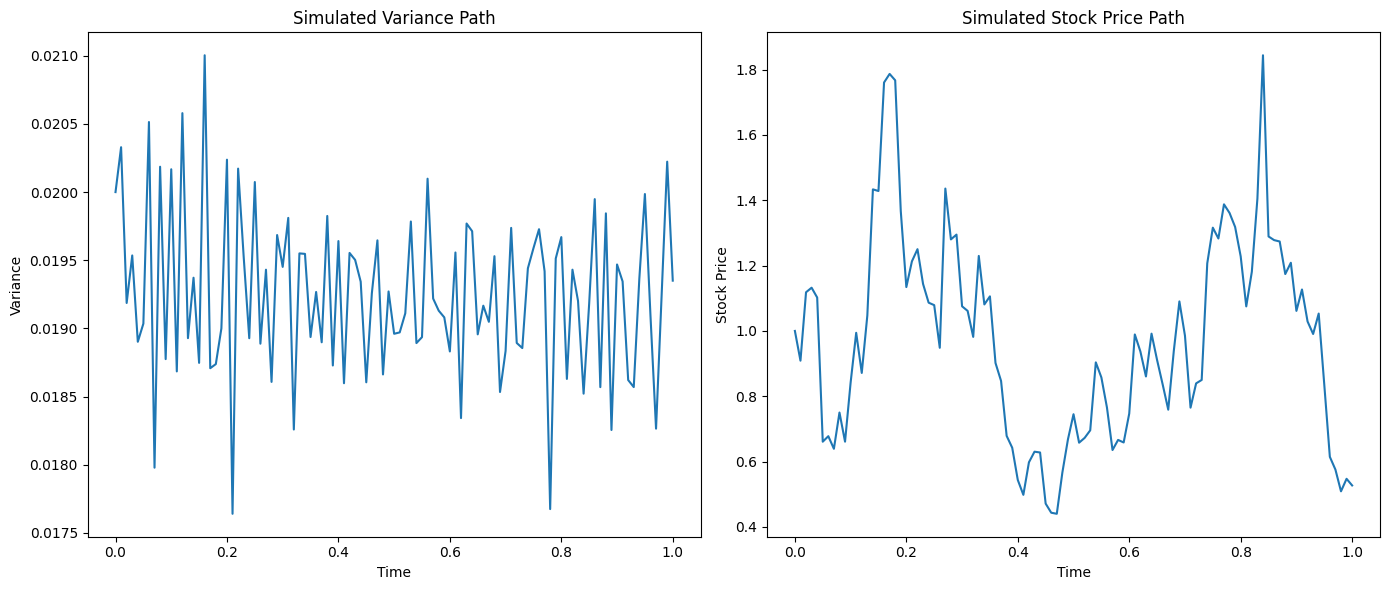

In [22]:
# Defining parameters
S0 = 1
V0 = 0.02
rho = -0.7
H = 0.07
lamb = 0.3
eta = 0.3
n = 10
T = 1
M = 100

# Performing simulation
t_grid, V, S = Sim_Lifted_Bergomi(S0, V0, rho, H, lamb, eta, n, T, M)

# Plotting the simulated variance and stock price
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot( t_grid, V)
plt.title('Simulated Variance Path')
plt.xlabel('Time')
plt.ylabel('Variance')

plt.subplot(1, 2, 2)
plt.plot( t_grid, S)
plt.title('Simulated Stock Price Path')
plt.xlabel('Time')
plt.ylabel('Stock Price')

plt.tight_layout()
plt.show()

## Question 2

In [23]:
def Call_Price_Lifted_Bergomi(S0, K, T, rho, H, lamb, eta, n, M, num_simulations):
    # Monte Carlo simulation of option payoffs
    payoffs = np.zeros(num_simulations)
    for i in range(num_simulations):
        # Simulating the variance and stock price paths
        t_grid, V_path, S_path = Sim_Lifted_Bergomi(S0, V0, rho, H, lamb, eta, n, T, M)
        # Calculating the payoff for a call option
        payoff = max(S_path[-1] - K, 0)
        payoffs[i] = payoff

    # Calculating the Monte Carlo estimate of the option price
    option_price_estimate = np.exp(-r * T) * np.mean(payoffs)
    return option_price_estimate


In [24]:
# Test the function with the given parameters
S0 = 1
K = 1.1  # Example strike price
T = 1  # Maturity in years
rho = -0.7  # Correlation
H = 0.07  # Roughness parameter
lamb = 0.3  # Speed of reversion
eta = 0.3  # Volatility of volatility
n = 10  # Number of factors
M = 100  # Number of time steps
num_simulations = 10000  # Number of simulation paths
r = 0  # Risk-free rate

# Calculating the call option price using the Lifted Bergomi model
call_option_price = Call_Price_Lifted_Bergomi(S0, K, T, rho, H, lamb, eta, n, M, num_simulations)
print("Call option price:", call_option_price)

Call option price: 1.7797413536601576


## Question 3

In [25]:
# Parameters for the Lifted Bergomi model
H = 0.1
eta = 1.9
rho = -0.9
S0 = 1
V0 = 0.02  # Epsilon_0(t) initial condition
T = 1  # Maturity
n = 10  # Number of factors for multi-factor approximation
num_simulations = 10000
num_time_steps = 100
strikes = np.linspace(0.5 * S0, 1.5 * S0, 50)  # Range of strikes to consider

In [26]:
# Given that `Sim_Lifted_Bergomi` function is implemented correctly
S_paths = np.zeros((num_simulations, num_time_steps + 1))
V_paths = np.zeros((num_simulations, num_time_steps + 1))
for i in range(num_simulations):
    t_grid, V_path, S_path = Sim_Lifted_Bergomi(S0, V0, rho, H, lamb, eta, n, T, num_time_steps)
    S_paths[i] = S_path
    V_paths[i] = V_path

In [27]:
def newton_raphson_volatility(S, K, T, call_price, initial_guess=0.2):
    """
    Newton-Raphson method to find the implied volatility given a market price of a call option.
    
    :param S: Current stock price
    :param K: Strike price
    :param T: Time to maturity
    :param r: Risk-free interest rate
    :param market_price: Market price of the option
    :param initial_guess: Initial guess for the implied volatility
    :return: Implied volatility
    """
    max_iterations = 100
    tolerance = 1e-6
    r = 0  # risk-free rate is zero
    # Black-Scholes call price function
    def black_scholes_call(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    # Vega (derivative of price with respect to volatility)
    def vega(sigma):
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        return S * norm.pdf(d1) * np.sqrt(T)

    # Newton-Raphson iteration
    sigma = initial_guess
    for i in range(max_iterations):
        price = black_scholes_call(sigma)
        vega_val = vega(sigma)
        diff = call_price - price  # Our root
        
        if abs(diff) < tolerance:
            return sigma

        sigma += diff / vega_val

    raise RuntimeError('Failed to converge within the maximum number of iterations')

We use the Newton-Raphson method to find the implied volatility for a given option price. The Newton-Raphson method is an iterative root-finding algorithm that can be used to solve for the implied volatility by finding the root of the equation that equates the option price calculated using the characteristic function to the observed market price.

In [28]:
def newton_raphson_method(f, df, x0, tol=1e-6, max_iter=1000):
    x = x0
    for _ in range(max_iter):
        fx = f(x)
        if abs(fx) < tol:
            return x
        dfx = df(x)
        if dfx == 0:
            raise ValueError("Division by zero in the Newton-Raphson method.")
        x -= fx / dfx
    raise ValueError("No convergence in the Newton-Raphson method.")

# Then we define the Black-Scholes call price function and its corresponding Vega (which is the derivative of the option price with respect to volatility)

def black_scholes_call(S, K, T, sigma):
    r = 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def vega(S, K, T, sigma):
    r = 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

# The implied volatility function is defined as follows:
def implied_volatility_call(S, K, T, market_price, initial_guess=0.2):
    def objective(sigma):
        return black_scholes_call(S, K, T, sigma) - market_price
    
    def vega_wrapper(sigma):
        return vega(S, K, T, sigma)
    
    return newton_raphson_method(objective, vega_wrapper, initial_guess)

In [31]:
# Defining the parameters
S0 = 20  # Initial VIX level
V0 = 0.04  # Initial annualized volatility squared (20% annualized volatility)
rho = -0.7  # Correlation coefficient
H = 0.1  # Hurst parameter for rough volatility
kappa = 1.0  # Speed of mean reversion (for Heston model)
theta = 0.04  # Long-term mean variance (for Heston model)
eta = 0.2  # Volatility of volatility
r = 0  # Risk-free rate (1%)
T = 1  # Maturity in years
M = 252  # Number of time steps (trading days in a year)
num_simulations = 10000  # Number of Monte Carlo simulations
K = [15, 17, 20, 22, 25]  # Array of different strike prices for testing
n = 10  # Number of factors for the Lifted/Rough Bergomi model
dt = 1/252  # Daily time steps

t_grid, V_paths, S_paths = Sim_Lifted_Bergomi(S0, V0, rho, H, lamb, eta, n, T, M)

# Calculating the call prices and implied volatilities using your functions
call_prices = [Call_Price_Lifted_Bergomi(S0, strike, T, rho, H, lamb, eta, n, M, num_simulations) for strike in K]
implied_vols = [implied_volatility_call(S0, strike, T, price) for strike, price in zip(K, call_prices)]

# Printing the results
for strike, price, iv in zip(K, call_prices, implied_vols):
    print(f"Strike: {strike}, Call Price: {price:.2f}, Implied Vol: {iv:.4f}")